# Prophet

...

**Packages**

In [1]:
import os
import numpy as np
import pandas as pd
import datetime
import itertools

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams 
import seaborn as sns

import os
from pathlib import Path
project_path = Path(os.getcwd()).parent
import pickle
import joblib  

np.random.seed(2530)

In [2]:
sns.set_style("whitegrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# # Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize

In [3]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

**Load data**

In [4]:
train_data_prophet = pd.read_parquet('../data/03_train-test/train_data_prophet.parquet')
test_data_prophet = pd.read_parquet('../data/03_train-test/test_data_prophet.parquet')
all_data_prophet = pd.read_parquet('../data/03_train-test/all_data_prophet.parquet')

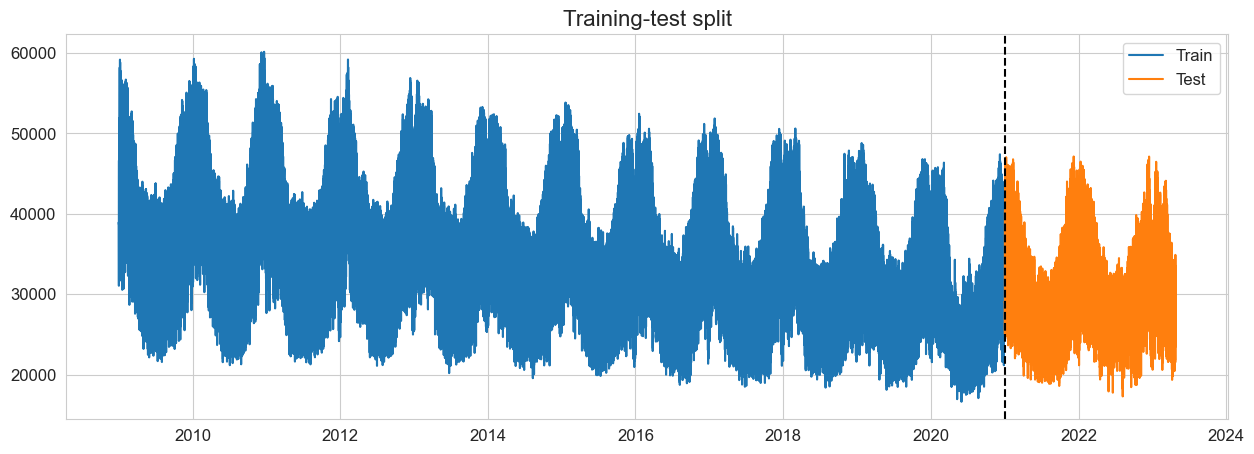

In [5]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(train_data_prophet['ds'], train_data_prophet['y'],  label="Train")
plt.plot(test_data_prophet['ds'], test_data_prophet['y'],  label="Test")
plt.axvline(datetime.date(2021,1,1), color="black", ls="--")
ax.set_title("Training-test split")
plt.legend();
plt.savefig("../graphs/train-test.png")

## First Prophet model

In [7]:
prophet_model = Prophet()

In [8]:
# fit the model
%%time
prophet_model.fit(train_data_prophet)

Wall time: 19min 21s


In [8]:
# compute predictions
prophet_predict_df = prophet_model.predict(test_data_prophet)
prophet_predict_df.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01 00:00:00,28118.036479,23057.302195,29682.951449,28118.036479,28118.036479,-1714.026218,-1714.026218,-1714.026218,-5486.336077,...,1450.697166,1450.697166,1450.697166,2321.612693,2321.612693,2321.612693,0.0,0.0,0.0,26404.010261
1,2021-01-01 00:30:00,28117.967210,22536.537420,29166.694363,28117.967210,28117.967210,-2215.649565,-2215.649565,-2215.649565,-5978.690844,...,1438.651263,1438.651263,1438.651263,2324.390016,2324.390016,2324.390016,0.0,0.0,0.0,25902.317645
2,2021-01-01 01:00:00,28117.897941,22302.912873,28970.862054,28117.897941,28117.897941,-2595.658649,-2595.658649,-2595.658649,-6348.728657,...,1425.886754,1425.886754,1425.886754,2327.183253,2327.183253,2327.183253,0.0,0.0,0.0,25522.239292
3,2021-01-01 01:30:00,28117.828672,21777.869194,28399.912029,28117.828672,28117.828672,-2935.690628,-2935.690628,-2935.690628,-6678.040543,...,1412.357534,1412.357534,1412.357534,2329.992381,2329.992381,2329.992381,0.0,0.0,0.0,25182.138044
4,2021-01-01 02:00:00,28117.759403,21645.655761,28373.751631,28117.759403,28117.759403,-3291.399058,-3291.399058,-3291.399058,-7022.232926,...,1398.016495,1398.016495,1398.016495,2332.817373,2332.817373,2332.817373,0.0,0.0,0.0,24826.360345


In [9]:
# save the model
joblib.dump(prophet_model, project_path.joinpath('data/models/prophet.pkl'))

['C:\\Users\\mpena\\OneDrive\\Escritorio\\TFG\\PYTHON\\data\\models\\prophet.pkl']

In [7]:
# load the model
# prophet_model = joblib.load(project_path.joinpath('data/models/prophet.pkl')) 

###### Prediction components

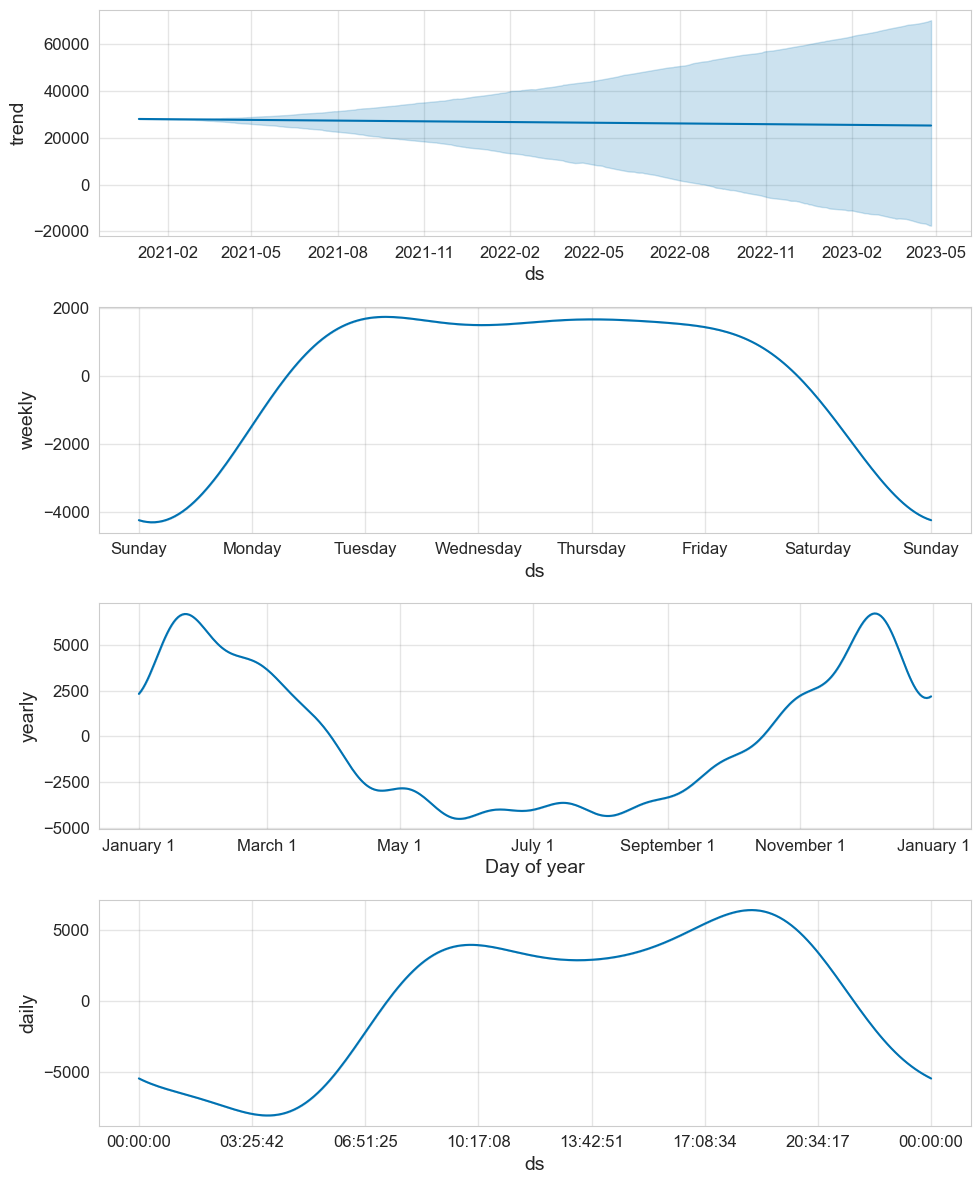

In [29]:
fig = prophet_model.plot_components(prophet_predict_df,figsize=(10,12))
plt.savefig("../graphs/prophet_comp.png")

###### Prediction on test set

In [9]:
## this is necessary to plot the model, since I have a older version of prophet

from __future__ import absolute_import, division, print_function

import logging

import numpy as np
import pandas as pd

from fbprophet.diagnostics import performance_metrics

logger = logging.getLogger('prophet.plot')



try:
    from matplotlib import pyplot as plt
    from matplotlib.dates import (
        MonthLocator,
        num2date,
        AutoDateLocator,
        AutoDateFormatter,
    )
    from matplotlib.ticker import FuncFormatter

    from pandas.plotting import deregister_matplotlib_converters
    deregister_matplotlib_converters()
except ImportError:
    logger.error('Importing matplotlib failed. Plotting will not work.')

try:
    import plotly.graph_objs as go
    from plotly.subplots import make_subplots
except ImportError:
    logger.error('Importing plotly failed. Interactive plots will not work.')

def prophet_plot(
    m, fcst, ax=None, uncertainty=True, plot_cap=True, xlabel='ds', ylabel='y',
    figsize=(10, 6), include_legend=False
):
    """Plot the Prophet forecast.

    Parameters
    ----------
    m: Prophet model.
    fcst: pd.DataFrame output of m.predict.
    ax: Optional matplotlib axes on which to plot.
    uncertainty: Optional boolean to plot uncertainty intervals, which will
        only be done if m.uncertainty_samples > 0.
    plot_cap: Optional boolean indicating if the capacity should be shown
        in the figure, if available.
    xlabel: Optional label name on X-axis
    ylabel: Optional label name on Y-axis
    figsize: Optional tuple width, height in inches.
    include_legend: Optional boolean to add legend to the plot.

    Returns
    -------
    A matplotlib figure.
    """
    if ax is None:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    fcst_t = fcst['ds'].dt.to_pydatetime()
    ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
            label='Observed data points')
    ax.plot(fcst_t, fcst['yhat'], ls='-', c='#0072B2', label='Forecast')
    if 'cap' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['cap'], ls='--', c='k', label='Maximum capacity')
    if m.logistic_floor and 'floor' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['floor'], ls='--', c='k', label='Minimum capacity')
    if uncertainty and m.uncertainty_samples:
        ax.fill_between(fcst_t, fcst['yhat_lower'], fcst['yhat_upper'],
                        color='#0072B2', alpha=0.2, label='Uncertainty interval')
    # Specify formatting to workaround matplotlib issue #12925
    locator = AutoDateLocator(interval_multiples=False)
    formatter = AutoDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if include_legend:
        ax.legend()
    fig.tight_layout()
    return fig

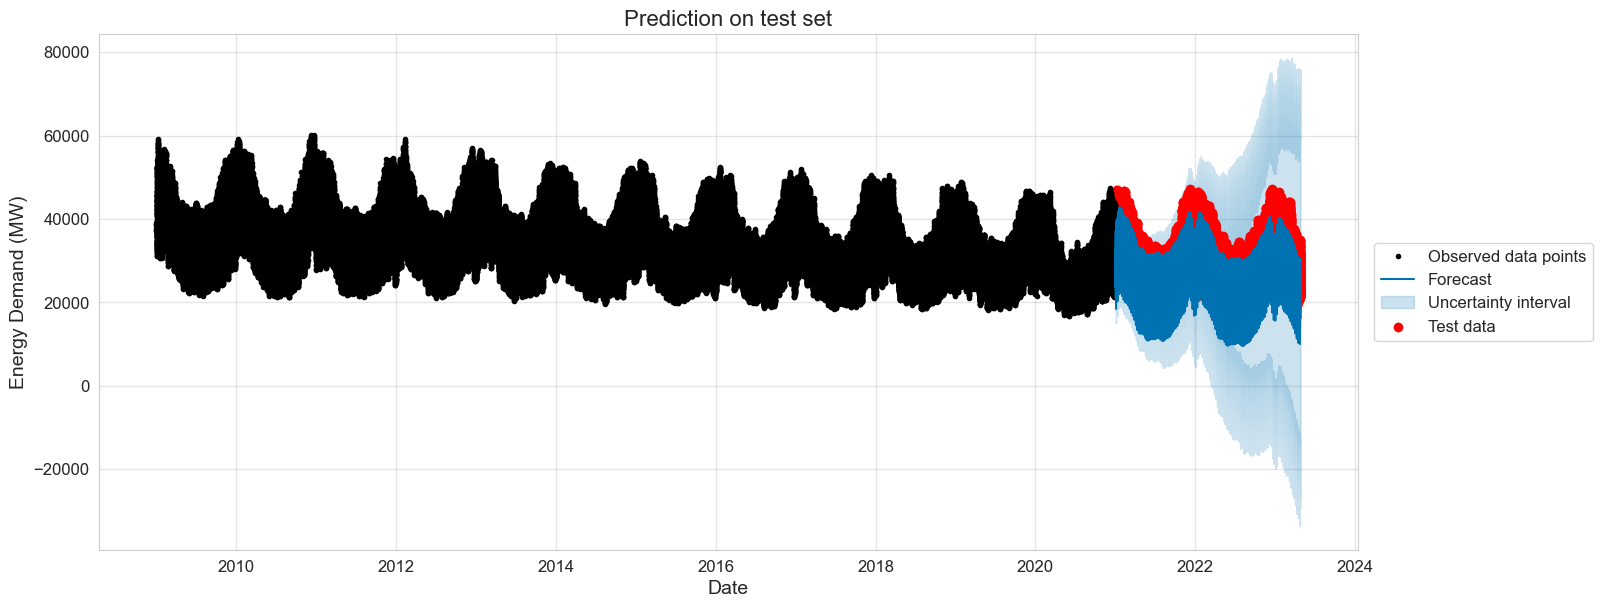

In [13]:
fig, ax = plt.subplots(figsize=(14, 6))

prophet_plot(m=prophet_model, fcst=prophet_predict_df, ax=ax, include_legend=True)
ax.scatter(test_data_prophet['ds'], test_data_prophet['y'], color='r', label="Test data")
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1)

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

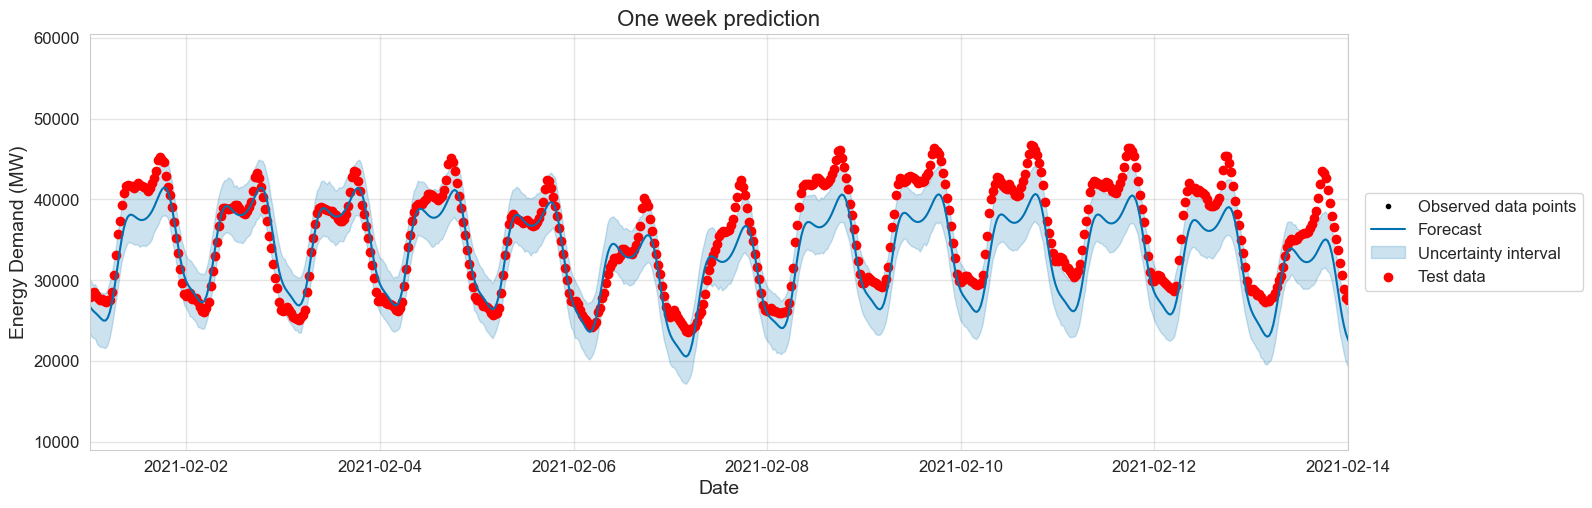

In [14]:
fig, ax = plt.subplots(figsize=(14,5))

prophet_plot(m=prophet_model, fcst=prophet_predict_df, ax=ax, include_legend=True)
ax.scatter(test_data_prophet['ds'], test_data_prophet['y'], color='r', label="Test data")
ax.set_xbound(lower=datetime.date(2021,2,1), upper=datetime.date(2021,2,14))
ax.set_ylim(9000, 60500)
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);
ax.set_title("One week prediction")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");
plt.savefig("../graphs/prophet_oneweek_pred.png")

###### MAPE error

In [15]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape
from sklearn.metrics import mean_squared_error

In [17]:
%%time
mape_prophet_simple = mean_absolute_percentage_error(
    test_data_prophet['y'], prophet_predict_df["yhat"]
)
rmse_prophet_simple = np.sqrt(mean_squared_error(test_data_prophet['y'], prophet_predict_df["yhat"]))
print(
    "Mean Absolute Percentage Error: %.2f"
    % mape_prophet_simple
)
print(
    "Root Mean Squared Error: %.2f MW" % rmse_prophet_simple
)

Mean Absolute Percentage Error: 11.87
Root Mean Squared Error: 4201.83 MW
Wall time: 1.99 ms


## Prophet with holidays

In [18]:
import holidays
bank_holiday_england = holidays.UK(subdiv="England", years=range(2009, 2024), observed=True).items()

In [19]:
# Create empty lists to store data
holiday_names = []
holiday_dates = []
holiday_names_observed = []
holiday_dates_observed = []

for date, name in sorted(bank_holiday_england):
    holiday_dates.append(date)
    holiday_names.append(name)
    # Pop the previous value as observed bank holidays takes place later
    if "Observed" in name:
        holiday_dates_observed.pop()
        holiday_names_observed.pop()

    holiday_names_observed.append(name)
    holiday_dates_observed.append(np.datetime64(date))

In [20]:
holiday_df = pd.DataFrame(data={"ds": holiday_dates_observed, "holiday": holiday_names_observed})
holiday_df.head()

,ds,holiday
0,2009-01-01,New Year's Day
1,2009-04-10,Good Friday
2,2009-04-13,Easter Monday
3,2009-05-04,May Day
4,2009-05-25,Spring Bank Holiday


In [22]:
# fit the model
%%time
prophet_hol_model = Prophet(holidays=holiday_df)
prophet_hol_model.fit(train_data_prophet)

Wall time: 23min 14s


In [22]:
#compute predictions
prophet_hol_predict_df = prophet_hol_model.predict(test_data_prophet)

In [23]:
# save the model
joblib.dump(prophet_hol_model, project_path.joinpath('data/models/prophet_hol_model.pkl'))

['C:\\Users\\mpena\\OneDrive\\Escritorio\\TFG\\PYTHON\\data\\models\\prophet_hol_model.pkl']

In [21]:
# load the model
# prophet_hol_model = joblib.load(project_path.joinpath('data/models/prophet_hol_model.pkl'))

###### Graphic of the components (now with holiday's effect)

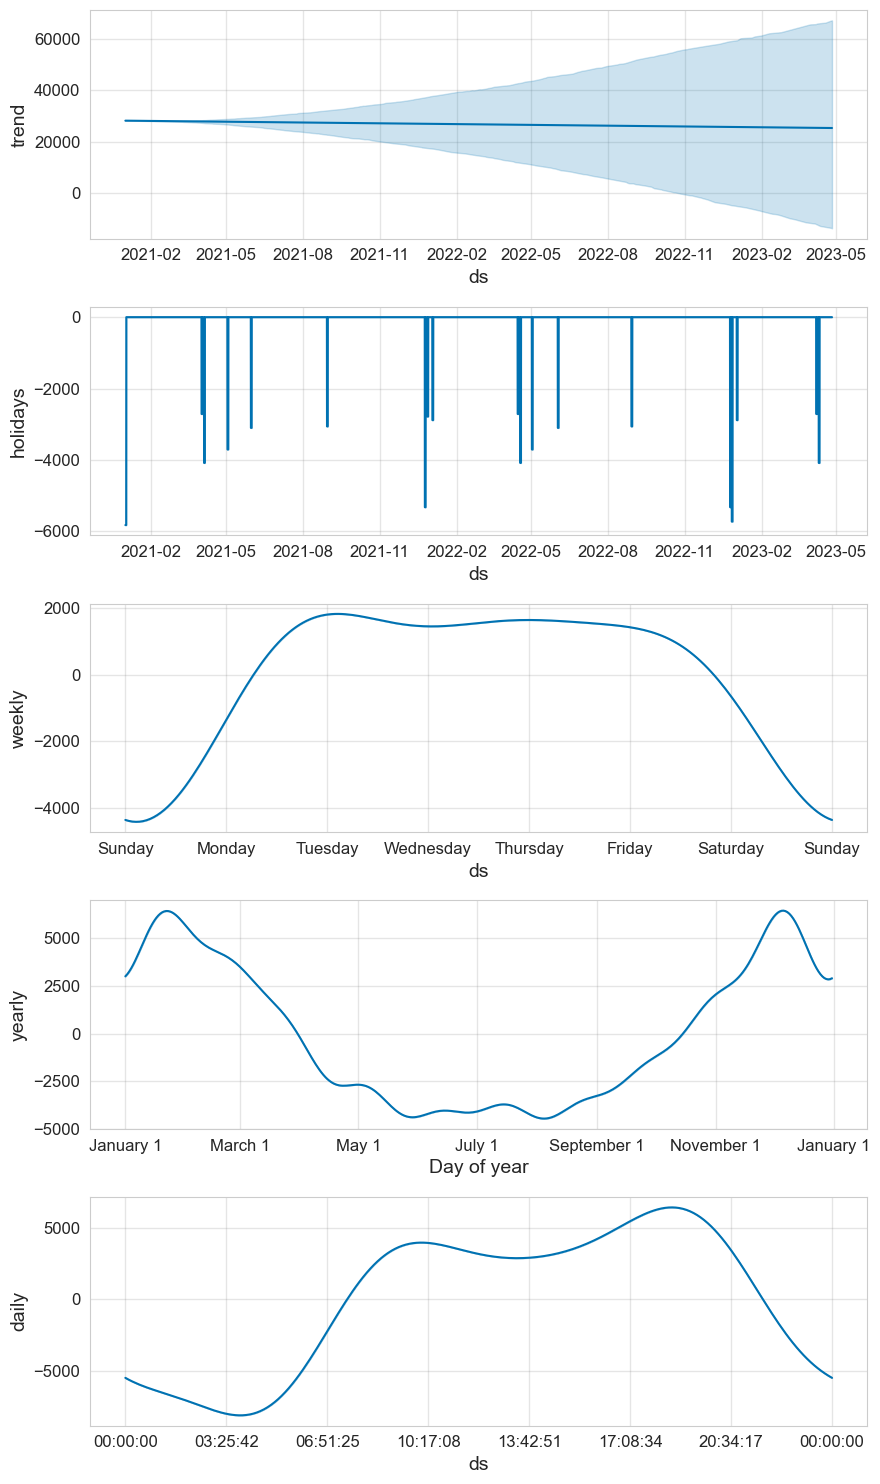

In [40]:
prophet_hol_model.plot_components(prophet_hol_predict_df);

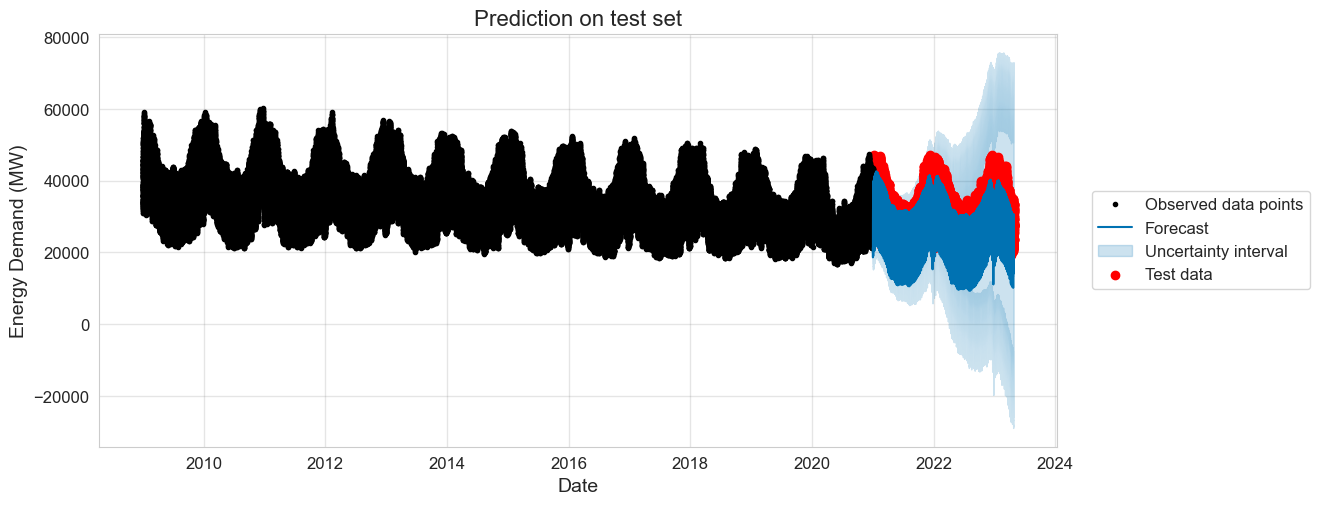

In [24]:
fig, ax = plt.subplots(figsize=(11, 5))

prophet_plot(m=prophet_hol_model, fcst=prophet_hol_predict_df, ax=ax, include_legend=True)
ax.scatter(test_data_prophet['ds'], test_data_prophet['y'], color='r', label="Test data")
ax.legend(bbox_to_anchor=(1.15, 0.5), loc="center", ncol=1)

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");
plt.savefig("../graphs/prophet_predition.png")

###### Comparison of the models in holidays

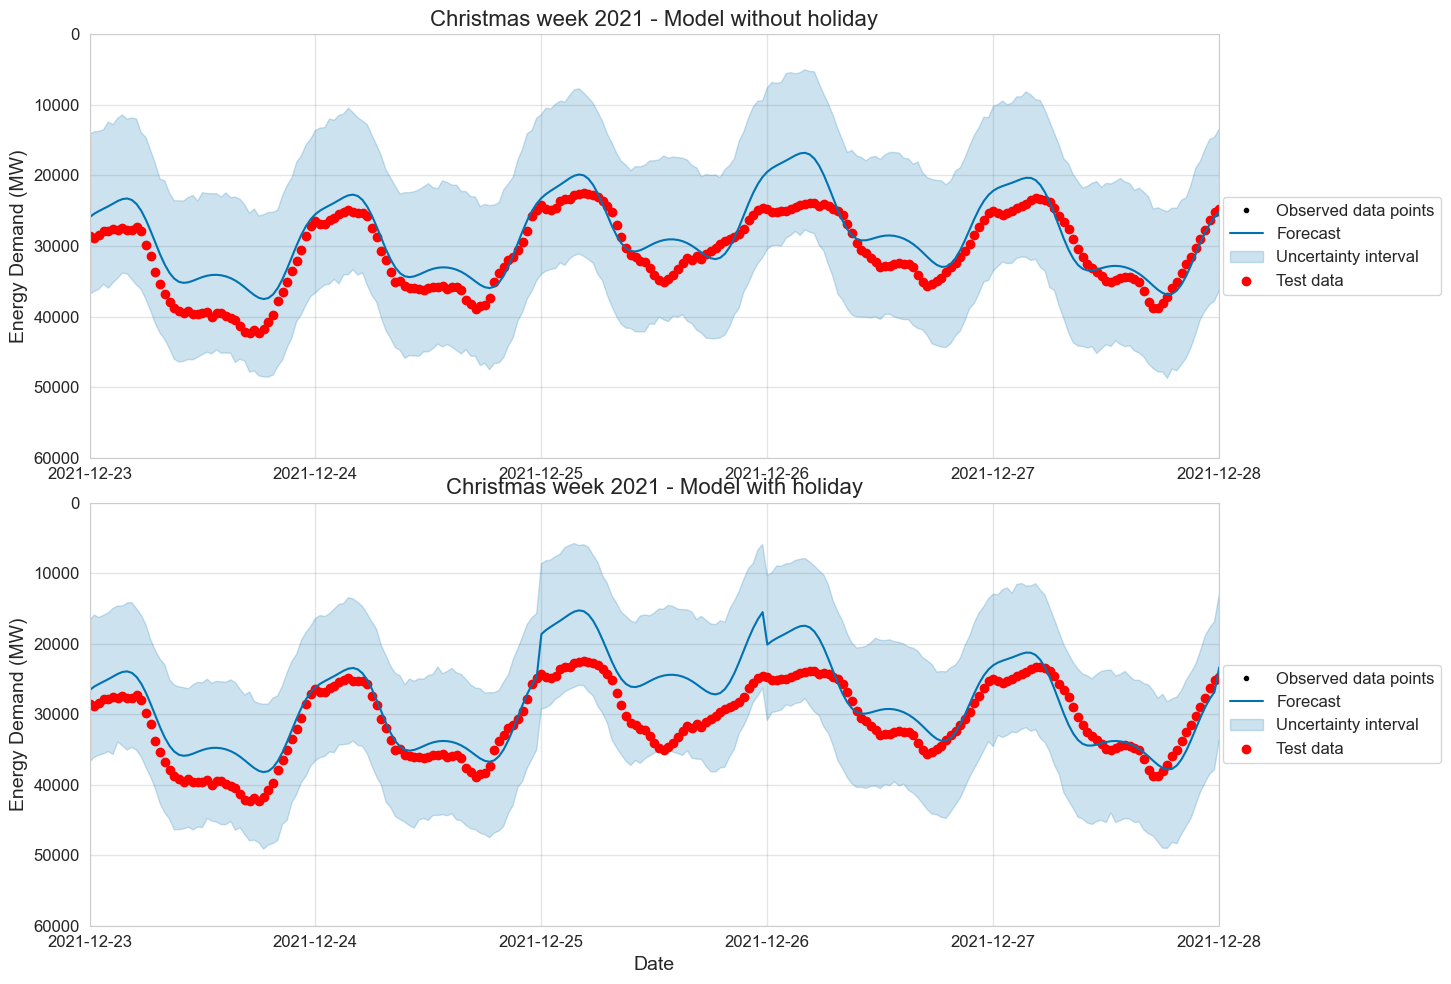

In [12]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,10))

prophet_plot(m=prophet_model, fcst=prophet_predict_df, ax=ax1, include_legend=True)
ax1.scatter(test_data_prophet['ds'], test_data_prophet['y'], color='r', label="Test data")
ax1.set_xlim(left=datetime.date(2021,12,23), right=datetime.date(2021,12,28))
ax1.set_ylim(bottom=60000, top=0)
ax1.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);
ax1.set_title("Christmas week 2021 - Model without holiday")
ax1.set_ylabel("Energy Demand (MW)")
ax1.set_xlabel("");



prophet_plot(m=prophet_hol_model, fcst=prophet_hol_predict_df, ax=ax2, include_legend=True)
ax2.scatter(test_data_prophet['ds'], test_data_prophet['y'], color='r', label="Test data")
ax2.set_xlim(left=datetime.date(2021,12,23), right=datetime.date(2021,12,28))
ax2.set_ylim(bottom=60000, top=0)
ax2.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);
ax2.set_title("Christmas week 2021 - Model with holiday")
ax2.set_ylabel("Energy Demand (MW)")
ax2.set_xlabel("Date");

# plt.savefig("../graphs/prophet_hdaycomparison.png")

##### MAPE error

In [25]:
mape_prophet_holiday = mean_absolute_percentage_error(
    test_data_prophet['y'], prophet_hol_predict_df["yhat"]
)
rmse_prophet_holiday = np.sqrt(mean_squared_error(test_data_prophet['y'], prophet_hol_predict_df["yhat"]))
print(
    "Mean Absolute Percentage Error: %.2f"
    % mape_prophet_holiday
)
print(
    "Root Mean Squared Error: %.2f MW" % rmse_prophet_holiday
)

Mean Absolute Percentage Error: 11.88
Root Mean Squared Error: 4204.48 MW


## Cross-Validation

In [26]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [27]:
df = pd.read_parquet('../data/02_intermediate/data.parquet')

threshold_date_1 = "06-01-2019"
threshold_date_2 = "06-01-2021"
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

# Prepare the training, testing and hold-out data
y_train = train_data['tsd']
y_test = test_data['tsd']
y_hold_out = hold_out_data['tsd']
y_all = df['tsd']

In [29]:
y_train

settlement_date
2009-01-01 00:00:00    38704
2009-01-01 00:30:00    38964
2009-01-01 01:00:00    38651
2009-01-01 01:30:00    37775
2009-01-01 02:00:00    37298
                       ...  
2019-05-31 21:30:00    27963
2019-05-31 22:00:00    27357
2019-05-31 22:30:00    25832
2019-05-31 23:00:00    24491
2019-05-31 23:30:00    23179
Name: tsd, Length: 181802, dtype: int64

In [31]:
df

,settlement_period,period_hour,tsd,is_holiday
settlement_date,,,,
2009-01-01 00:00:00,1,0:00:00,38704,1
2009-01-01 00:30:00,2,0:30:00,38964,1
2009-01-01 01:00:00,3,1:00:00,38651,1
2009-01-01 01:30:00,4,1:30:00,37775,1
2009-01-01 02:00:00,5,2:00:00,37298,1
...,...,...,...,...
2023-04-25 21:30:00,44,21:30:00,31142,0
2023-04-25 22:00:00,45,22:00:00,29292,0
2023-04-25 22:30:00,46,22:30:00,27807,0


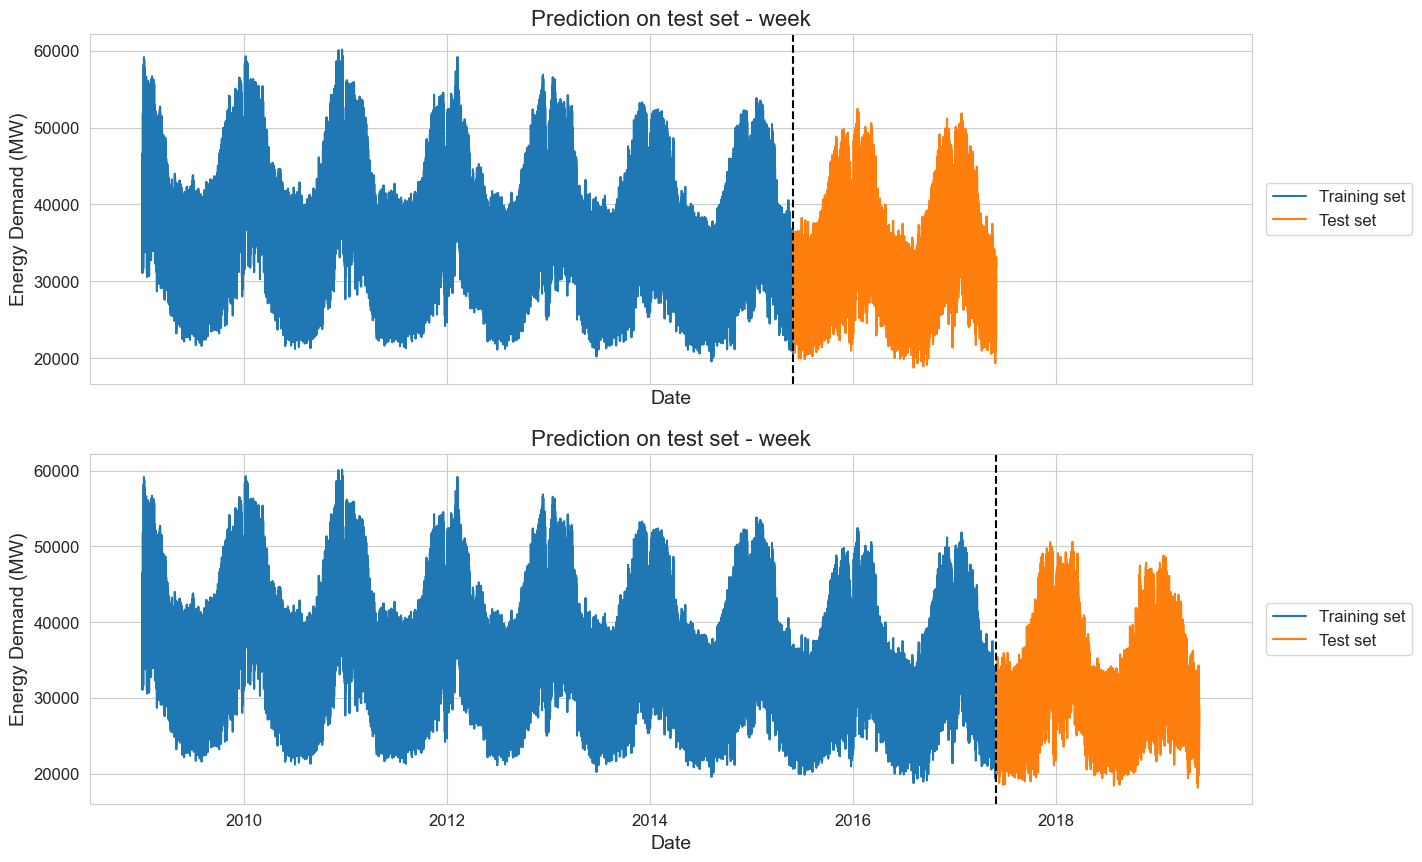

In [30]:
n_years_test = 2
tss_prophet = TimeSeriesSplit(n_splits=2, test_size=48 * 365 * n_years_test, gap=48)

fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

fold = 0
for train_index, test_index in tss_prophet.split(df[df.index<threshold_date_1]):
    train_data = y_train.to_frame() \
                        .reset_index() \
                        .iloc[train_index] \
                        .rename(columns={"settlement_date": "ds", "tsd": "y"})

    test_data = y_train.to_frame() \
                    .reset_index() \
                    .iloc[test_index] \
                    .rename(columns={"settlement_date": "ds", "tsd": "y"})
    
    axes[fold].plot(train_data["ds"], train_data["y"], label="Training set")
    axes[fold].plot(test_data["ds"], test_data["y"], label="Test set")
    axes[fold].axvline(test_data["ds"].min(), color="k", ls="--")
    axes[fold].legend(loc="center", bbox_to_anchor=(1.075, 0.5))

    axes[fold].set_title("Prediction on test set - week")
    axes[fold].set_ylabel("Energy Demand (MW)")
    axes[fold].set_xlabel("Date");
    fold += 1
    
plt.savefig("../graphs/prophet_crossval.png")

In [36]:
%%time

# Define the parameter grid for the Prophet model
param_grid = {"changepoint_prior_scale": [0.05], "seasonality_prior_scale": [2.5, 10]}

# Create all possible combinations of the parameter grid
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

rmse_cv_gs = []

for params in all_params:
    rmse_cv = []
    
    for train_index, test_index in tss_prophet.split(df[df.index<threshold_date_1]):
        train_data = y_train.to_frame() \
                            .reset_index() \
                            .iloc[train_index] \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})

        test_data = y_train.to_frame() \
                            .reset_index() \
                            .iloc[test_index] \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})

        model = Prophet(**params, holidays=holiday_df)
        model.fit(train_data)

        prediction = model.predict(test_data)
        mse_val = mean_squared_error(test_data["y"], prediction["yhat"])
        rmse_cv.append(np.sqrt(mse_val))
    
    rmse_cv_gs.append(np.mean(rmse_cv))
    
grid_search_results = pd.DataFrame(all_params)
grid_search_results['rmse'] = rmse_cv_gs

grid_search_results

Wall time: 1h 56min 56s


,changepoint_prior_scale,seasonality_prior_scale,rmse
0,0.05,2.5,2927.673645
1,0.05,10.0,2922.044670


## Model with the best parameters

In [37]:
best_params = all_params[np.argmin(rmse_cv_gs)]
print(best_params)

{'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10}


In [6]:
best_params = {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10}

In [ ]:
%%time
# Create Prophet using the best parameters from the grid search
prophet_best = Prophet(**best_params, holidays=holiday_df)
prophet_best.fit(train_data_prophet)

prophet_best_predict_df = prophet_best.predict(test_data_prophet)

In [51]:
# save the model
joblib.dump(prophet_best, project_path.joinpath('data/models/prophet_best.pkl'))

['C:\\Users\\mpena\\OneDrive\\Escritorio\\TFG\\PYTHON\\data\\models\\prophet_best.pkl']

In [7]:
# load the model
# prophet_best = joblib.load(project_path.joinpath('data/models/prophet_best.pkl'))
# prophet_best_predict_df = prophet_best.predict(test_data_prophet)

###### MAPE error

In [45]:
mape_prophet_cv_gs = mean_absolute_percentage_error(
    test_data_prophet['y'], prophet_best_predict_df["yhat"]
)
rmse_prophet_cv_gs = np.sqrt(
    mean_squared_error(test_data_prophet['y'], prophet_best_predict_df["yhat"])
)
print(
    "Mean Absolute Percentage Error of the best-parameters Prophet model is: %.2f"
    % mape_prophet_cv_gs
)
print(
    "Root Mean Squared Error of the Prophet (with cross-validation) model is: %.2f MW" % rmse_prophet_cv_gs
)

Mean Absolute Percentage Error of the best-parameters Prophet model is: 11.88
Root Mean Squared Error of the Prophet (with cross-validation) model is: 4204.48 MW


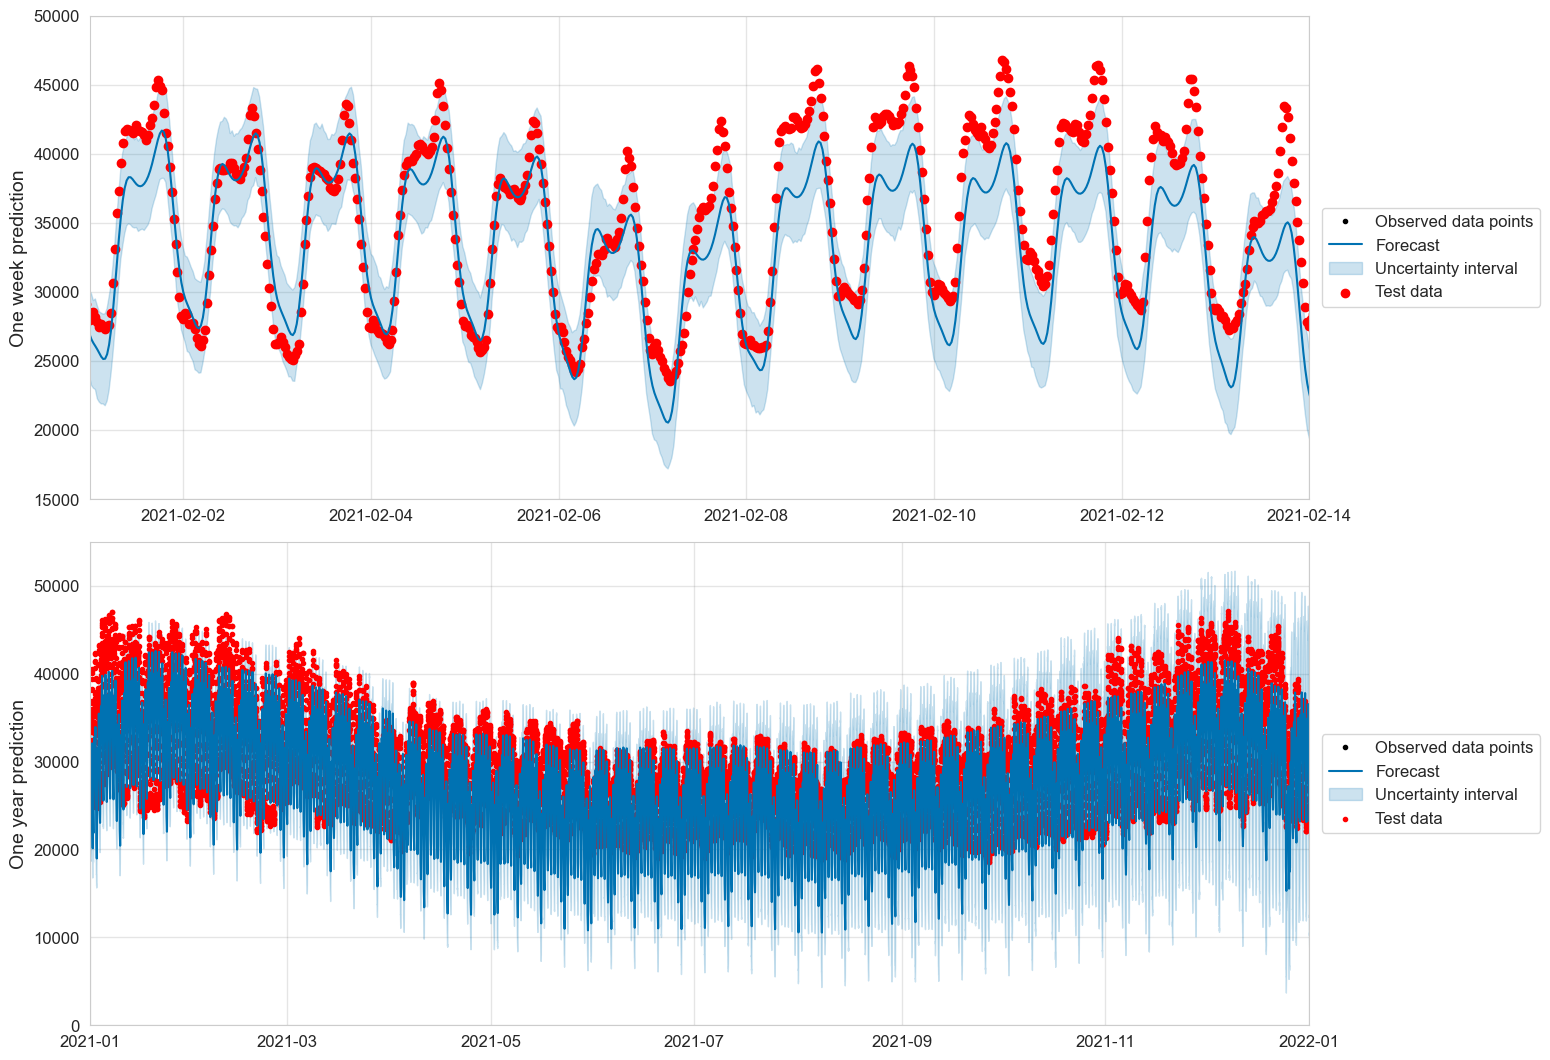

In [33]:
fig, (ax, bx) = plt.subplots(2,1,figsize=(16,11))

prophet_plot(m=prophet_best, fcst=prophet_best_predict_df, ax=ax, include_legend=True)
ax.scatter(test_data_prophet['ds'], test_data_prophet['y'], color='r', label="Test data")
ax.set_xbound(lower=datetime.date(2021,2,1), upper=datetime.date(2021,2,14))
ax.set_ylim(15000, 50000)
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);
ax.set_ylabel("One week prediction")
ax.set_xlabel("");


prophet_plot(m=prophet_best, fcst=prophet_best_predict_df, ax=bx, include_legend=True)
bx.scatter(test_data_prophet['ds'], test_data_prophet['y'], marker='.',color='r', label="Test data")
bx.set_xbound(lower=datetime.date(2021,1,1), upper=datetime.date(2022,1,1))
bx.set_ylim(0, 55000)
bx.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);
bx.set_ylabel("One year prediction")
bx.set_xlabel("");

plt.savefig("../graphs/prophet_pred2.png")

## Prediction into the future

In [14]:
%%time
# Fit a new model using all the data as training data
prophet_future_model = Prophet(**best_params, holidays=holiday_df)
prophet_future_model.fit(all_data_prophet)

Wall time: 20min 42s


In [28]:
# Make predictions on future dataframe
prophet_future = prophet_future_model.make_future_dataframe(periods=210*24, freq="H", include_history=False)
prophet_fut_forecast = prophet_future_model.predict(prophet_future)

In [16]:
# save the model
joblib.dump(prophet_future_model, project_path.joinpath('data/models/prophet_future_model.pkl'))

['C:\\Users\\mpena\\OneDrive\\Escritorio\\TFG\\PYTHON\\data\\models\\prophet_future_model.pkl']

In [27]:
# load the model
# prophet_future_model = joblib.load(project_path.joinpath('data/models/prophet_future_model.pkl'))

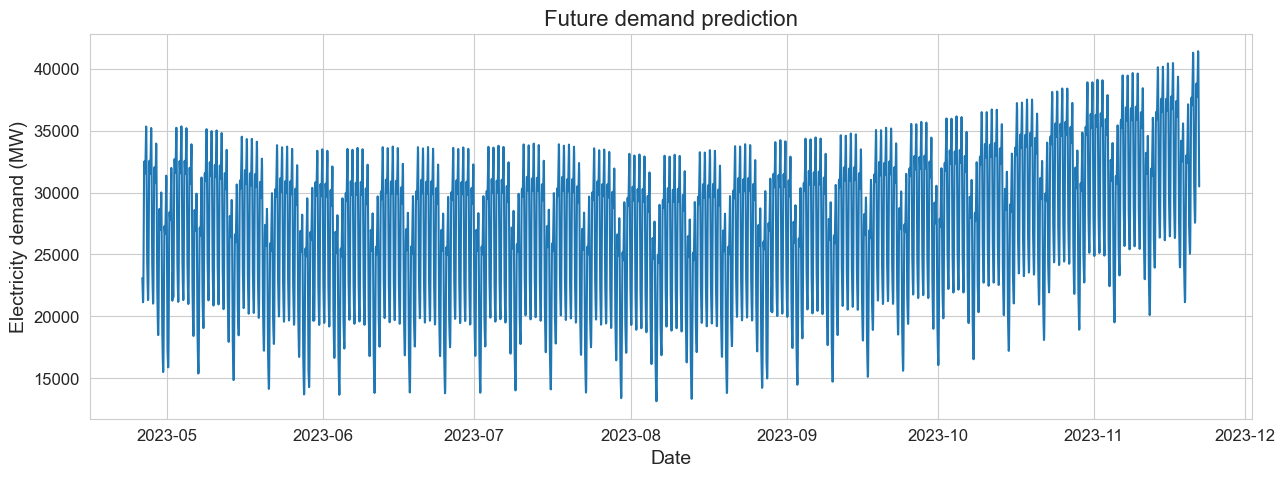

In [29]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(prophet_fut_forecast["ds"], prophet_fut_forecast["yhat"])

ax.set_xlabel("Date")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Future demand prediction")
plt.savefig("../graphs/prophet_future_predition.png")